В общем. Делаем k-means вручную (там не сильно сложно), сверяем потом результаты с реализацией из sklearn (в ней еще пробуем k-medoids)
Датасет я прикрепил, суть в чем: нужно прежде всего попробовать исключить Genre и попробовать облегчить себе задачу его определения через k-means: разбить на выбранное вами k, посмотреть в получившиеся кластеры, понять, к чему они относятся, можно ли при оптимальном выборе k в один кластер собрать male, в другой - female (кластеров не обязательно два). Помимо этого, поэкспериментировать с разным k, описать, что получается в кластерах и чем это может быть полезно.

In [1]:
import scipy
import pandas as pd 
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, precision_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from sklearn_extra.cluster import KMedoids

In [2]:
df=pd.read_csv('Mall_Customers.csv')
df

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [3]:
#diag_map = {'Male': 1, 'Female': -1}
#df['Genre'] = df['Genre'].map(diag_map)

In [4]:
#train,test=train_test_split(df,test_size=0.2,random_state=0)
#X=df.iloc[:,2:]
X = df.iloc[:, [3, 4]].values

In [6]:

#X_train,y_train=train.iloc[:,2:],train['Genre']
#X_test,y_test=test.iloc[:,2:],test['Genre']

In [7]:
class Kmeans:
    def __init__(self,X,K):
        self.X=X
        self.Output={}
        self.Centroids=np.array([]).reshape(self.X.shape[1],0)
        self.K=K
        self.WCSS_array=np.array([])
        self.m=self.X.shape[0]
        
    def kmeanspp(self,X,K):
        i=rd.randint(0,X.shape[0])
        Centroid_temp=np.array([X[i]])
        for k in range(1,K):
            D=np.array([]) 
            for x in X:
                D=np.append(D,np.min(np.sum((x-Centroid_temp)**2)))
            prob=D/np.sum(D)
            cummulative_prob=np.cumsum(prob)
            r=rd.random()
            i=0
            for j,p in enumerate(cummulative_prob):
                if r<p:
                    i=j
                    break
            Centroid_temp=np.append(Centroid_temp,[X[i]],axis=0)
        return Centroid_temp.T
    
    def fit(self,n_iter):
        #randomly Initialize the centroids
        self.Centroids=self.kmeanspp(self.X,self.K)
        
        #compute euclidian distances and assign clusters
        for n in range(n_iter):
            EuclidianDistance=np.array([]).reshape(self.m,0)
            for k in range(self.K):
                tempDist=np.sum((self.X-self.Centroids[:,k])**2,axis=1)
                EuclidianDistance=np.c_[EuclidianDistance,tempDist]
            C=np.argmin(EuclidianDistance,axis=1)+1
            #adjust the centroids
            Y={}
            for k in range(self.K):
                Y[k+1]=np.array([]).reshape(2,0)
            for i in range(self.m):
                Y[C[i]]=np.c_[Y[C[i]],self.X[i]]
        
            for k in range(self.K):
                Y[k+1]=Y[k+1].T
            for k in range(self.K):
                self.Centroids[:,k]=np.mean(Y[k+1],axis=0)
                
            self.Output=Y
            
    
    def predict(self):
        return self.Output,self.Centroids.T
    

In [8]:
m=X.shape[0] #number of training examples
#n=X.shape[1] #number of features. Here n=2
n_iter=100


In [9]:
WCSS_array=np.array([])
for K in range(1,11):
    kmeans=Kmeans(X,K)
    kmeans.fit(n_iter)
    Output,Centroids=kmeans.predict()
    wcss=0
    for k in range(K):
        wcss+=np.sum((Output[k+1]-Centroids[k,:])**2)
    WCSS_array=np.append(WCSS_array,wcss)

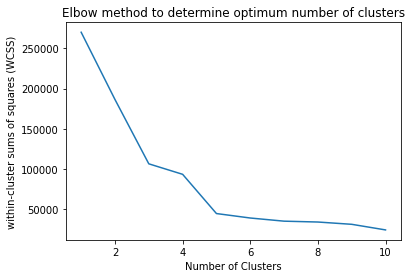

In [10]:
K_array=np.arange(1,11,1)
plt.plot(K_array,WCSS_array)
plt.xlabel('Number of Clusters')
plt.ylabel('within-cluster sums of squares (WCSS)')
plt.title('Elbow method to determine optimum number of clusters')
plt.show()

Идея состоит в том, что нам нужен небольшой WCSS, но WCSS имеет тенденцию уменьшаться до 0 по мере увеличения k (WCSS равен 0, когда k равно количеству точек данных в наборе данных, потому что тогда каждая точка данных является собственной. кластер, и между ним и центром кластера нет ошибки). Итак, наша цель - выбрать небольшое значение k, которое все еще имеет низкое значение WCSS, а изгиб обычно показывает, где мы начинаем получать убывающую отдачу при увеличении k.

In [11]:
K=5
kmeans=Kmeans(X,K)
kmeans.fit(n_iter)
Output_hand,Centroids_hand=kmeans.predict()

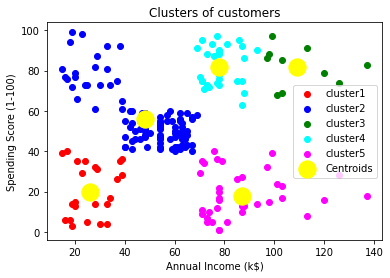

In [12]:
color=['red','blue','green','cyan','magenta']
labels=['cluster1','cluster2','cluster3','cluster4','cluster5']
for k in range(K):
    plt.scatter(Output_hand[k+1][:,0],Output_hand[k+1][:,1],c=color[k],label=labels[k])
plt.scatter(Centroids_hand[:,0],Centroids_hand[:,1],s=300,c='yellow',label='Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

## K-means from SKLearn

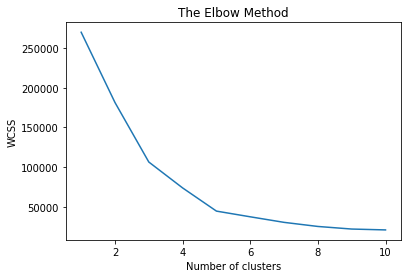

In [13]:
wcss_means = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    wcss_means.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss_means)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state =0)
y_kmeans=kmeans.fit_predict(X)


<bound method BaseEstimator.set_params of KMeans(n_clusters=5, random_state=0)>

In [79]:
data={'Genre':[i for i in df.Genre.values],
      'Claster':[i for i in y_kmeans],
      'Income':[x[0] for x in X],
      'Score':[x[1] for x in X]
     }

In [81]:
df_final=pd.DataFrame(data)
df_final

,Genre,Claster,Income,Score
0,Male,4,15,39
1,Male,3,15,81
2,Female,4,16,6
3,Female,3,16,77
4,Female,4,17,40
...,...,...,...,...
195,Female,2,120,79
196,Female,0,126,28
197,Male,2,126,74
198,Male,0,137,18


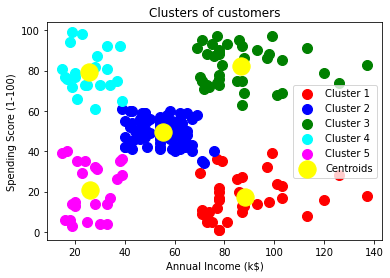

In [17]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

('Male', 2, array([137,  83], dtype=int64))

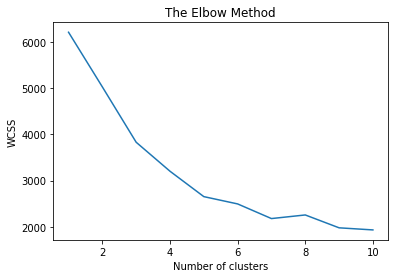

In [18]:
wcss_medoids = []
for i in range(1, 11):
    kmedoids = KMedoids(n_clusters=i,init='k-medoids++',random_state=0)
    #kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmedoids.fit(X)
    #kmeans.fit(X)
    wcss_medoids.append(kmedoids.inertia_)
plt.plot(range(1, 11), wcss_medoids)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [19]:
kmedoids = KMedoids(n_clusters=5,init='k-medoids++',random_state=0)
y_kmedoids=kmedoids.fit_predict(X)

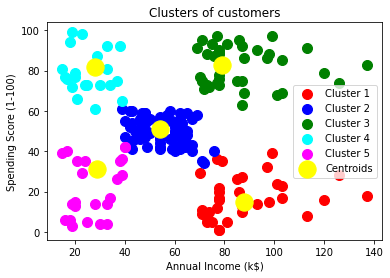

In [20]:
plt.scatter(X[y_kmedoids == 0, 0], X[y_kmedoids == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmedoids == 1, 0], X[y_kmedoids == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmedoids == 2, 0], X[y_kmedoids == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmedoids == 3, 0], X[y_kmedoids == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmedoids == 4, 0], X[y_kmedoids == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()